####  Segment customers using RFM analysis and k-means ++ clustering
RFM stands for the three dimensions:  
Recency – How recently did the customer purchase?  
Frequency – How often do they purchase?  
Monetary Value – How much do they spend?  
RFM analysis is a behavior-based approach grouping customers into segments. It could help companies provide better service, identify potential customers and do more profitable business.  

The steps of RFM analysis to segment customers are:  
1.Calculate the Recency, Frequency, Monetary values for each customer.  
2.Assign a score for each dimension on a scale from 1 to 4 using quartile.  
3.Concate all scores in single RFM score  
4.Segment customers according to their RFM sore

In [20]:
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#from IPython.display import display, HTML


In [2]:
# Import processed data
df = pd.read_excel("processed data.xlsx",index_col=0, dtype={'CustomerID': str,'InvoiceNo': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,Weekday,weekday_name,DAY_OF_WEEK
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes,2,Wednesday,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,2,Wednesday,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes,2,Wednesday,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,2,Wednesday,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,2,Wednesday,Wednesday


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 13 columns):
InvoiceNo       397884 non-null object
StockCode       397884 non-null object
Description     397884 non-null object
Quantity        397884 non-null int64
InvoiceDate     397884 non-null datetime64[ns]
UnitPrice       397884 non-null float64
CustomerID      397884 non-null object
Country         397884 non-null object
amount          397884 non-null float64
Internal        397884 non-null object
Weekday         397884 non-null int64
weekday_name    397884 non-null object
DAY_OF_WEEK     397884 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 42.5+ MB


In [4]:
df1 = df.copy()
df1.duplicated().sum()

5192

In [5]:
df1.drop_duplicates(inplace = True)
print(df.shape)
print(df1.shape)

(397884, 13)
(392692, 13)


### Part 1 Use RFM score to segement customers
#### 1). Calculate the Recency, Frequency, Monetary values for each customer

* Recency

In [6]:
# Set a reference date 
reference_date = df1.InvoiceDate.max() + datetime.timedelta(days = 1)
print('reference date: ',reference_date)

# Calculate recency
df1['days_since_referencedate'] = (reference_date - df1.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  df1[['CustomerID', 'days_since_referencedate']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_referencedate':'recency'}, inplace=True)
#customer_history_df.head()
customer_history_df.describe().transpose()

reference date:  2011-12-10 12:50:00


,count,mean,std,min,25%,50%,75%,max
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0


In [7]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()


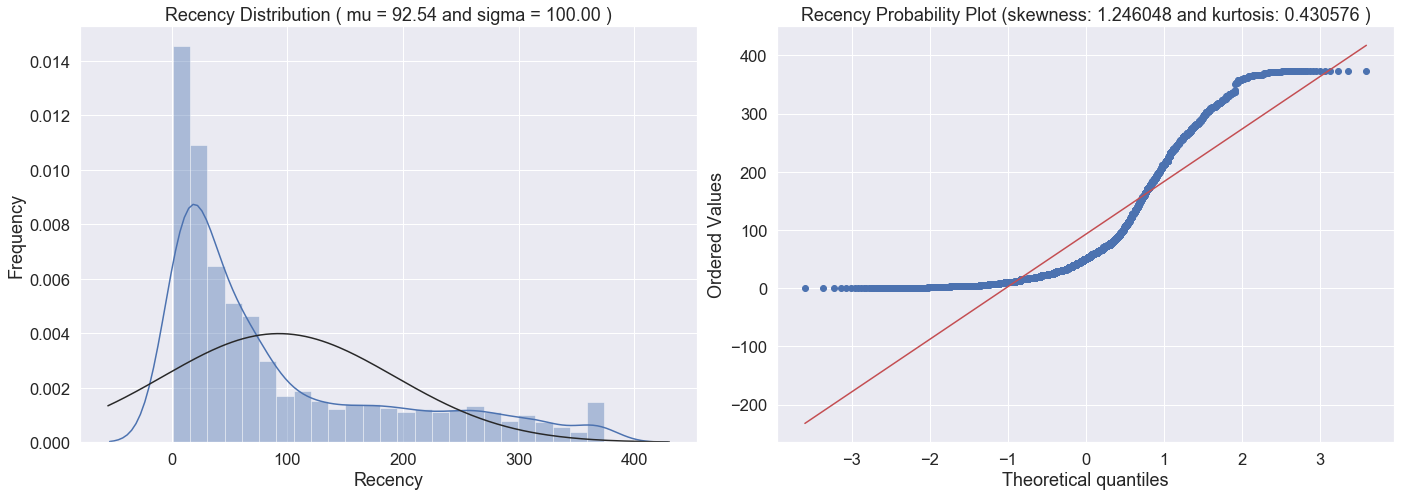

In [8]:

QQ_plot(customer_history_df.recency, 'Recency')

* Frequency

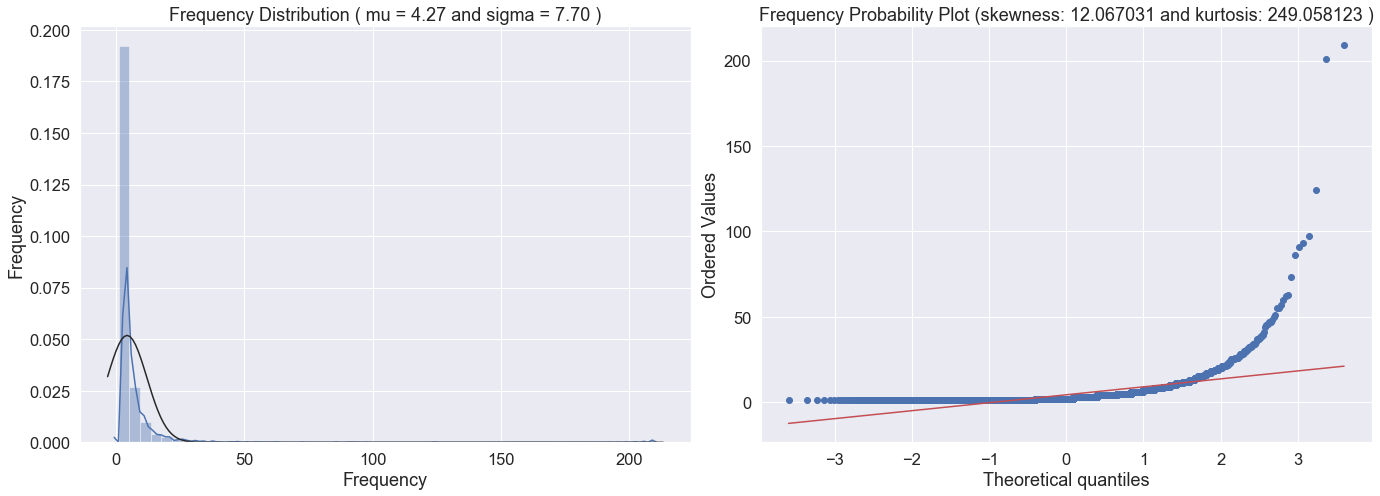

In [9]:
customer_freq = (df1[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

* Monetary Value

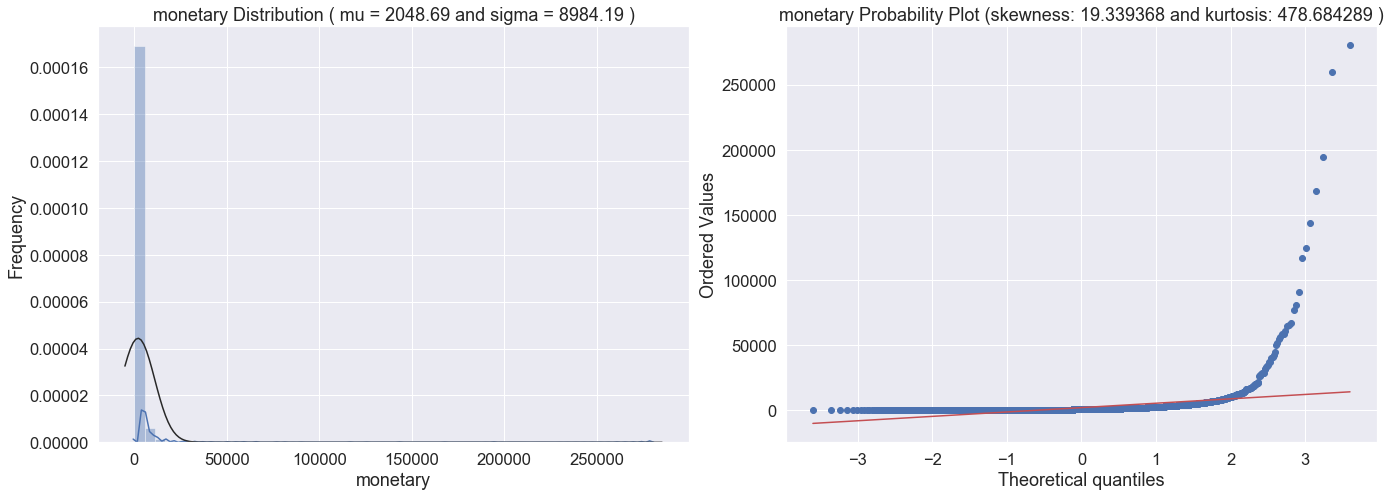

In [10]:

customer_monetary_val = df1[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
customer_history_df.rename(columns={'amount':'monetary'}, inplace=True)
QQ_plot(customer_history_df.monetary, 'monetary')

In [11]:
customer_history_df.head()

,CustomerID,recency,frequency,monetary
0,12346,326.0,1,77183.60
1,12347,2.0,7,4310.00
2,12348,75.0,4,1797.24
3,12349,19.0,1,1757.55
4,12350,310.0,1,334.40


In [12]:
customer_history_df.describe()

,recency,frequency,monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081
std,100.014169,7.697998,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


#### 2). Assign a score for each dimension on a scale from 1 to 4 using quartile

In [13]:
# Use quantile to divide the RFM values
quantiles = customer_history_df.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary': {0.25: 306.48249999999996,
  0.5: 668.5699999999999,
  0.75: 1660.5975000000012}}

In [14]:
def Rscore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
def FMscore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [15]:
# Divide R,F,M values into four levels in the scale of 1-4
segment_rfm = customer_history_df.copy()
segment_rfm['r_quartile'] = segment_rfm['recency'].apply(Rscore, args=('recency',quantiles,))
segment_rfm['f_quartile'] = segment_rfm['frequency'].apply(FMscore, args=('frequency',quantiles,))
segment_rfm['m_quartile'] = segment_rfm['monetary'].apply(FMscore, args=('monetary',quantiles,))
segment_rfm.head()

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,12346,326.0,1,77183.60,4,4,1
1,12347,2.0,7,4310.00,1,1,1
2,12348,75.0,4,1797.24,3,2,1
3,12349,19.0,1,1757.55,2,4,1
4,12350,310.0,1,334.40,4,4,3


#### 3). Concate all scores in single RFM score

In [16]:
# Calculate RFM score = r*100+f*10+m, 111 is highest RFM score
segment_rfm['RFMScore'] = segment_rfm.r_quartile.map(str) \
                              + segment_rfm.f_quartile.map(str) \
                              + segment_rfm.m_quartile.map(str)

segment_rfm.head()

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,326.0,1,77183.60,4,4,1,441
1,12347,2.0,7,4310.00,1,1,1,111
2,12348,75.0,4,1797.24,3,2,1,321
3,12349,19.0,1,1757.55,2,4,1,241
4,12350,310.0,1,334.40,4,4,3,443


#### 4). Segment customers according to their RFM sore

- 0 - 122, the most valuable customers, who are not very sensitive to the price. so this kind of customers could be selected to promote loyalty projects and new products
- 122 - 223, customers who are gradually lost, so email or channel promotion should be given to them.
- 223 - 333, valuable customers who are not very active recently, need to activate further by giving a discount or email promotion

how to segment customers would be varied mainly depending on company's operational capabilities

In [17]:
segment_rfm['RFMScore'] = segment_rfm['RFMScore'].astype(int)

def rfm_level(RFMScore):
    if (RFMScore >= 0 and RFMScore < 122):
        return '1'
    elif (RFMScore >= 122 and RFMScore < 223):
        return '2'
    elif (RFMScore >= 223 and RFMScore < 333):
        return '3'
    return '4'

segment_rfm['RFMScore_level'] = segment_rfm['RFMScore'].apply(rfm_level).astype(str)
segment_rfm.head()

,CustomerID,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,RFMScore_level
0,12346,326.0,1,77183.60,4,4,1,441,4
1,12347,2.0,7,4310.00,1,1,1,111,1
2,12348,75.0,4,1797.24,3,2,1,321,3
3,12349,19.0,1,1757.55,2,4,1,241,3
4,12350,310.0,1,334.40,4,4,3,443,4


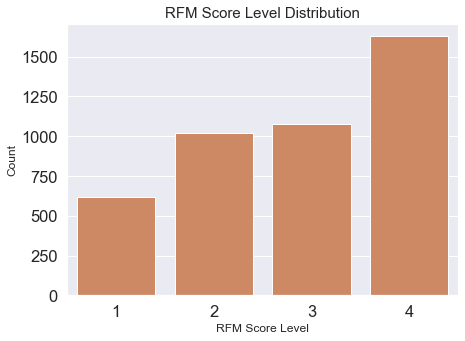

In [18]:
# Plot distribution of RFM score
plt.figure(figsize=(7,5))
sns.countplot(x='RFMScore_level',data=segment_rfm, color = color[1])
plt.ylabel('Count',fontsize=12)
plt.xlabel('RFM Score Level', fontsize=12)
plt.xticks()
plt.title('RFM Score Level Distribution',fontsize=15)
plt.show()

### Part 2 Use K-means++ to segement customers

In [19]:
segment_rfm.describe()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081,2.486169,2.679806,2.500000,277.914938
std,100.014169,7.697998,8985.230220,1.126296,1.143825,1.118369,119.655140
min,1.000000,1.000000,3.750000,1.000000,1.000000,1.000000,111.000000
25%,18.000000,1.000000,306.482500,1.000000,2.000000,1.250000,144.000000
50%,51.000000,2.000000,668.570000,2.000000,3.000000,2.500000,244.000000
75%,142.000000,5.000000,1660.597500,3.000000,4.000000,3.750000,344.000000
max,374.000000,209.000000,280206.020000,4.000000,4.000000,4.000000,444.000000


In [23]:
# Standardising the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feature_vector = ['recency','frequency','monetary']
X_subset = customer_history_df[feature_vector] 
X_scaled = scaler.fit_transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe()

,recency,frequency,monetary
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,2.702618e-17,1.801745e-17,-6.551800e-18
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.153401e-01,-4.250965e-01,-2.276151e-01
25%,-7.453445e-01,-4.250965e-01,-1.939190e-01
50%,-4.153533e-01,-2.951776e-01,-1.536162e-01
75%,4.946227e-01,9.457903e-02,-4.319704e-02
max,2.814561e+00,2.659803e+01,3.096074e+01


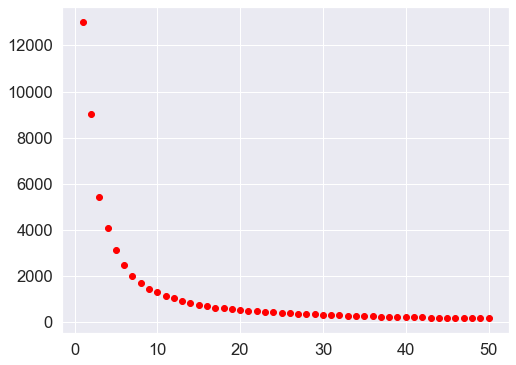

In [24]:
# Choose the Right Number of Clusters using elbow curve
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

In [25]:
K_best

11

The best K sugest:  11


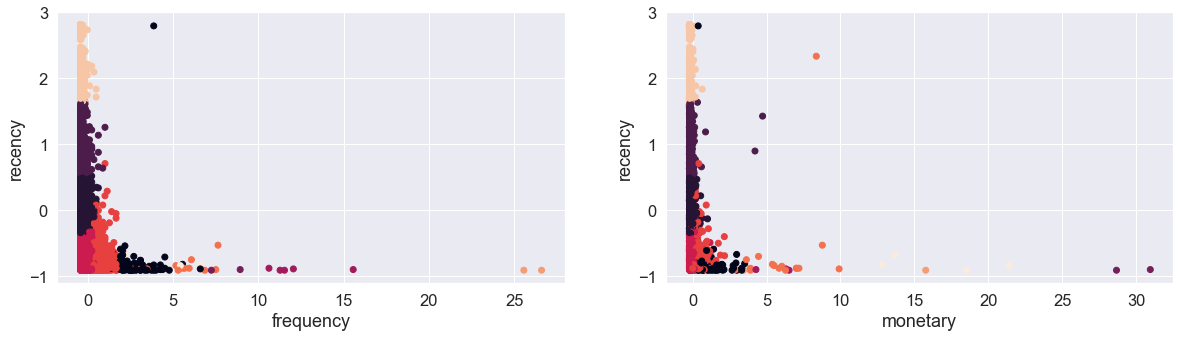

In [26]:
# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

In [28]:
segment_rfm['recency_log'] = segment_rfm['recency'].apply(math.log)
segment_rfm['frequency_log'] = segment_rfm['frequency'].apply(math.log)
segment_rfm['monetary_log'] = segment_rfm['monetary'].apply(math.log)
scaler = StandardScaler()
feature_vector = ['recency_log','frequency_log','monetary_log']
X_subset = segment_rfm[feature_vector] 
X_scaled = scaler.fit_transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe()

,recency_log,frequency_log,monetary_log
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,-1.048288e-16,-9.991495e-17,3.275900e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.630445e+00,-1.048610e+00,-4.172381e+00
25%,-6.124235e-01,-1.048610e+00,-6.820955e-01
50%,1.147066e-01,-2.790440e-01,-6.385708e-02
75%,8.296516e-01,7.382675e-01,6.572740e-01
max,1.505796e+00,4.882714e+00,4.722173e+00


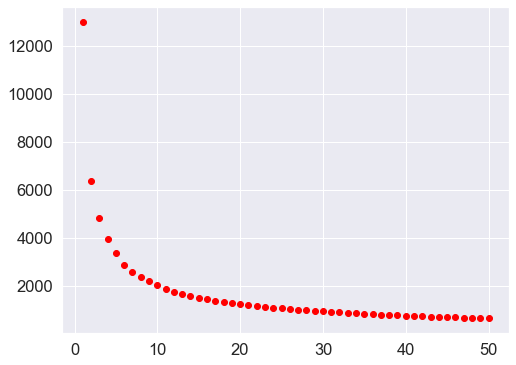

In [29]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

The best K sugest:  7


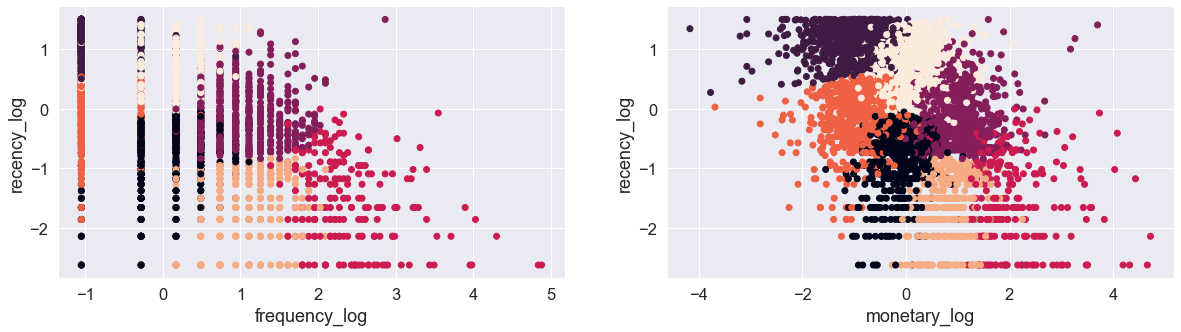

In [30]:
# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()